## Dans ce notebook :

on test un encoder multimodal qui prend en entrée les coordonnées 
et les features extraites d'un Resnet. On utilise le principe de Cross-Attention du papier "Multi-modal 
Transformers", on utilise ensuite le décoder classique (transformer aussi)

In [1]:
import pandas as pd
import sqlite3
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader 
import torchvision
from torchvision import datasets 
from torch.nn.functional import softmax
from torchvision.transforms import ToTensor 
from torchvision.utils import save_image
from torch.distributions.normal import Normal

from PIL import Image

import math
from copy import deepcopy
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import datetime
import cv2
from skimage.util import img_as_ubyte
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import argparse

from datetime import datetime

from IPython import display

# Log
from torch.utils.tensorboard import SummaryWriter

#Transformer Decoder
from models.scratch_transformer.decoder import TransformerDecoder
from models.cross_attention_transformer.encoder import Encoder
from models.cross_attention_transformer.encoder_layer import EncoderLayer

torch.autograd.set_detect_anomaly(True)

In [2]:
__file__=os.getcwd()
print(__file__)

#Dataset name
dataset_name = "eth" # dataset options: 'university', 'zara_01', 'zara_02', 'eth', 'hotel'

/notebook_data/github_repo


In [3]:
now = datetime.now() # current date and time
current_time_date = now.strftime("%d_%m_%y_%H_%M_%S")
run_folder  = "Outputs/traj_pred_"+ dataset_name + "_" + str(os.path.basename(__file__)) + str(current_time_date)
os.makedirs(run_folder)

In [4]:
# Make log folder for tensorboard
#SummaryWriter_path = run_folder + "/log"
#os.makedirs(SummaryWriter_path) 
SummaryWriter_path = '/notebook_data/work_dirs/cross_attention_test_1'
  
writer = SummaryWriter(SummaryWriter_path,comment="ADE_FDE_Train")

# Make image folder to save outputs
image_path  = run_folder + "/Visual_Prediction"
os.makedirs(image_path)

In [5]:
#DataBase Variables
image_folder_path       = '/notebook_data/data/data_trajpred/'+dataset_name
DB_PATH_train     = '/notebook_data/data/data_trajpred/'+dataset_name+"/pos_data_train.db"
cnx_train         = sqlite3.connect(DB_PATH_train)
DB_PATH_val     = '/notebook_data/data/data_trajpred/'+dataset_name+"/pos_data_val.db"
cnx_val         = sqlite3.connect(DB_PATH_val)
DB_DIR      = run_folder + '/database'
os.makedirs( DB_DIR )
DB_PATH2    = DB_DIR+'/db_one_ped_delta_coordinates_results.db'
cnx2        = sqlite3.connect(DB_PATH2)

#Other variables
T_obs                   = 8
T_pred                  = 12
T_total                 = T_obs + T_pred #8+12=20
data_id                 = 0 
batch_size              = 4 #10#100 #15 #2
chunk_size              = batch_size * T_total # Chunksize should be multiple of T_total
in_size                 = 2
stochastic_out_size     = in_size * 2
hidden_size             = 256 #!64
embed_size              = 64 #16 #!64
global dropout_val
dropout_val             = 0.2 #0.5
teacher_forcing_ratio   = 0.7 # 0.9
regularization_factor   = 0.5 # 0.001
avg_n_path_eval         = 20
bst_n_path_eval         = 20
path_mode               = "top5" #"avg","bst","single","top5"
regularization_mode     = "regular" #"weighted","e_weighted", "regular"
startpoint_mode         = "on" #"on","off"
enc_out                 = "on" #"on","off"
biased_loss_mode        = 0 # 0 , 1


table_out   = "results_delta"
table       = "dataset_T_length_20delta_coordinates" #"dataset_T_length_"+str(T_total)+"delta_coordinates"
df_id       = pd.read_sql_query("SELECT data_id FROM "+table, cnx_train)
data_size   = df_id.data_id.max() * T_total
epoch_num   = 100
from_epoch  = 0

#Visual Variables
image_size              = 256  
image_dimension         = 3
mask_size               = 16
visual_features_size    = 128 
visual_embed_size       = 64  #128 #256 #64
vsn_module_out_size    = 256
to_pil = torchvision.transforms.ToPILImage()


#Model Path
model_path = run_folder + "/NNmodel" 
os.makedirs(model_path)   
model_path = model_path + str("/model")

In [6]:
stochastic_mode         = 1 #output  

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.device_count()
torch.cuda.current_device()

0

In [8]:

# Matrice Standard
if dataset_name == 'eth':  
    h = np.array([[2.8128700e-02, 2.0091900e-03, -4.6693600e+00],[8.0625700e-04, 2.5195500e-02, -5.0608800e+00],[ 3.4555400e-04, 9.2512200e-05, 4.6255300e-01]]) #h pour eth
if dataset_name =='hotel':        
    h = np.array([[1.1048200e-02, 6.6958900e-04, -3.3295300e+00],[-1.5966000e-03, 1.1632400e-02, -5.3951400e+00],[1.1190700e-04, 1.3617400e-05, 5.4276600e-01]]) #h pour hotel
if dataset_name =='zara01': 
    h = np.array([[0.02174104, 0, -0.15],[0, -0.02461883, 13.77429807],[0, 0, 1]]) #h pour zara1
if dataset_name =='zara02': 
    h = np.array([[0.02174104, 0, -0.4],[0, -0.02386598, 14.98401686],[0, 0, 1]]) #h pour zara2
if dataset_name =='univ':
    h = np.array([[0.02220407, 0, -0.48],[0, -0.02477289, 13.92551292],[0, 0, 1]]) #h pour univ

# Classe Dataset

In [9]:
from src.TrajectoryDataset import TrajectoryPredictionDataset

# Initialize random weights for NN models

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.2, 0.2)

# Regularizer loss

In [11]:
sum_sigma_distance  = torch.zeros(1) #tensor[(0.)]

def distance_from_line_regularizer(input_tensor,prediction):
    global sum_sigma_distance
    #the regularization is defined as the sum of Euclidean distances between each step of the predicted trajectory Tf , and a line fitted to the observed trajectory To.
    # Fit a line to observation points over batch 
    input_tensor    = input_tensor.double()
    prediction      = prediction.double()
    input_tensor    = input_tensor.cumsum(dim=1).double()
    X               = torch.ones_like(input_tensor).double().to('cuda', non_blocking=True)
    X[:,:,0]        = input_tensor[:,:,0]
    Y               = (input_tensor[:,:,1]).unsqueeze(-1).double()
    try:
        try:
            XTX_1           = torch.matmul( X.transpose(-1,-2), X).double().inverse()
        except:
            XTX_1           = torch.matmul( X.transpose(-1,-2), X).double().pinverse()
        XTY             = torch.matmul( X.transpose(-1,-2), Y)
        theta           = torch.matmul( XTX_1.double(), XTY.double())
        # Calculate real values of prediction instead of delta
        prediction[:,:,0] = prediction[:,:,0] + input_tensor[:,-1,0].unsqueeze(-1) 
        prediction[:,:,1] = prediction[:,:,1] + input_tensor[:,-1,1].unsqueeze(-1)
        
        # Calculate distance ( predicted_points , observation_fitted_line ) over batch
        theta0x0        = theta[:,0,:].double() * prediction[:,:,0].double()
        denominator     = torch.sqrt( theta[:,0,:].double() * theta[:,0,:].double() + 1 )
        nominator       = theta0x0 + theta[:,1,:] - prediction[:,:,1].double()
        distance        = nominator.abs() / denominator
        if regularization_mode =='weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().float(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(-1,T_pred)
            weighted_distance   = weight * distance

        elif regularization_mode =='e_weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().float(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(distance.size(0),T_pred)
            weight              = torch.exp(weight)
            weighted_distance   = weight*distance

        else:
            weighted_distance = distance
        sigma_distance  = torch.mean(weighted_distance,1)
        sum_sigma_distance  = torch.mean(sigma_distance)
        return sum_sigma_distance
    except:
        print("SINGULAR VALUE")
        sum_sigma_distance = torch.zeros(1).to('cuda', non_blocking=True) + 20
        return sum_sigma_distance

# Encoder Transformer (Cross-Attention)

In [12]:
# class EncoderSelfAttentionNew(nn.Module):
#     def __init__(self,device,d_model, d_k, d_v, n_head, dff=2048, dropout_transformer=.1, n_module=6):
#         super(EncoderSelfAttentionNew, self).__init__()
        
        
#         self.encoder = nn.ModuleList([MultiHeadAttention(d_model, d_k, d_v, n_head, dff, dropout_transformer)
#                                       for _ in range(n_module)])
#         self.device = device
#     def forward(self, x):
    
        
        
#         for l in self.encoder:
#             in_encoder = l(in_encoder, in_encoder, in_encoder)
#         return in_encoder
    


class EncoderLayer(nn.Module):
    """
    Encoder Layer du papier "Multimodal Transformer", cf fig 2 du papier
    """
    def __init__(self,device,d_model, d_k, d_v, n_head, code_size=1024, dff=2048, dropout_transformer=.1, n_module=3):
        super(EncoderLayer, self).__init__()
        
        self.self_attention = ScaledDotProductAttention(d_model, d_k, d_v, n_head)
        
        #Celle du haut dans le papier
        self.cross_attention_features = ScaledDotProductAttention(d_model, d_k, d_v, n_head)
        #Celle du bas dans le papier
        self.cross_attention_coords = ScaledDotProductAttention(d_model, d_k, d_v, n_head)
        
        self.ffn_coords = nn.Linear(d_model, code_size)
        self.ffn_features = nn.Linear(d_model, code_size)
        
        self.dropout = nn.Dropout(p=dropout_transformer)
        self.layer_norm = nn.LayerNorm(code_size)
        self.relu = nn.ReLU()
        
    def forward(self, in_encoder_coords, in_encoder_features):
        """
        Encoder Layer return 2 output
        
        """
        
        coords_self_att = self.self_attention(in_encoder_coords,in_encoder_coords,in_encoder_coords)
        
        cross_attention_features = self.cross_attention_features(in_encoder_features,coords_self_att,coords_self_att)
        
        cross_attention_coords = self.cross_attention_coords(coords_self_att,in_encoder_features,in_encoder_features)
        
        out_coords = self.relu(self.ffn_coords(cross_attention_coords))
        
        out_features = self.relu(self.ffn_features(cross_attention_features))
        
        out_coords = self.dropout(out_coords)
        out_features = self.dropout(out_features) 
        
        
        
        
        return self.layer_norm(out_coords), self.layer_norm(out_features)
        
        
class EncoderTransformer(nn.Module):
    """
    Encoder Transformer adapted from the MTN Paper.
    It only takes as input the (x,y) coordinates as in our case the camera is static (the MTN was used for a dynamic "ego-car" context)
    """
    def __init__(self,device,code_size,d_k, d_v,n_head=8,n_module=3,ff_size=2048,dropout1d=0.5, feature_size=512):
        super(EncoderTransformer, self).__init__()
        self.device = device
        self.fc_coords = nn.Linear(2,code_size)
        self.fc_features = nn.Linear(feature_size,code_size)
        
        self.encoder = nn.ModuleList([EncoderLayer(device,code_size, d_k, d_v, n_head, dff=ff_size, dropout_transformer=dropout1d, code_size=code_size)
                                      for _ in range(n_module)])
        
        self.relu =  nn.ReLU()
        
        
        self.pool = nn.AdaptiveAvgPool2d((8,code_size)) #final pooling
        self.dropout = nn.Dropout(dropout1d)
        
    def forward(self, coords, features):
        """
        coords : sequence of coordinates
        features : sequence of features extracted from a ResNet
        
        """
        batch_size = coords.shape[0]
        
        coords = self.relu(self.fc_coords(coords))
        
        in_encoder_coords = coords + sinusoid_encoding_table(coords.shape[1], coords.shape[2]).expand(coords.shape).to(self.device)
        
#         print(f"Shape of features{features.size()}")
#         print(f"Shape of features{self.fc_features(features).size()}")
        
        in_encoder_features = self.relu(self.fc_features(features))
        
        for layer in self.encoder:
            out_enc_coords, out_enc_features = layer(in_encoder_coords, in_encoder_features)
        #out_enc_coords, out_enc_features = self.encoder(in_encoder_coords, in_encoder_features)
        
        code = (out_enc_coords+out_enc_features).to(device).double()
        
        return code


# Resnet_Transformer_Vision Encoder

### Spatial features extraction (Resnet 18)

In [13]:
def Resnet(pretrain=True,layers_to_unfreeze=8,layers_to_delete=2,in_planes=3):
    """
    param:
        pretrain: Define if we load a pretrained model from ImageNet
        layers_to_unfreeze: Define the number of layers that we want to train at the end of the Resnet
        layers_to_delete: Define the numbers of layers that we want to delete
        in_planes: Define the numbers of input channels of images (supported values: 1,2 or 3)
    return: The Resnet model
    """
    resnet = torchvision.models.resnet18(pretrained=pretrain)
    # Create a new model cause we don't want the pooling operation at the end and the classifier
    model = nn.Sequential()
    number_of_layers = len(list(resnet.children())) - layers_to_delete # In practice it remove the pooling operation and the classifier

    if number_of_layers<layers_to_unfreeze:
        layers_to_unfreeze = number_of_layers
    layers_to_freeze = number_of_layers - layers_to_unfreeze
    i=0
    for child in resnet.children():
        # For the first layers we create a new weight if in_planes is not 3 cause ResNet is pretrain on image with 3 channels there is no version for 1 channel
        if i==0 and in_planes<3:
            if i<layers_to_freeze: # Define if we freeze this layer or no
                for param in child.parameters():
                    param.requires_grad = False # Freeze the layers by passing requires_grad attribute to False
            w = child._parameters['weight'].data # Get the weight for 3 channels data
            child._modules['0'] = nn.Conv2d(in_planes, 64, kernel_size=3, padding=1) # Define the new conv layer
            if in_planes == 1:
                child._parameters['weight'].data = w.mean(dim=1, keepdim=True) # If the number of channels is 1 we made the mean of channels to set the new weight
            else:
                child._parameters['weight'].data = w[:, :-1] * 1.5

        if i<layers_to_freeze: # Define if we freeze this layer or no
            for param in child.parameters():
                param.requires_grad = False # Freeze the layers by passing requires_grad attribute to False
        if i<number_of_layers: # To define if we keep this layer or not
            model.append(child) 
        i+=1
    return model


class features_extraction(nn.Module):
    """
    param:
    conv_model: The convolution model used before capsules for the moment only ResNet is supported
    in_planes: Numbers of channels for the image
    """
    def __init__(self,conv_model,in_planes: int):
        super().__init__()
        self.conv_model = conv_model
        self.in_planes = in_planes
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
    def forward(self,input):
        shape = input.size()
        x = input.view(-1,self.in_planes,shape[-2],shape[-1])
        x = self.conv_model(x)
        x = self.pooling(x)
        return x

### Encoder Transformer (Vision)

In [14]:
def position_embedding(input, d_model):
    input = input.view(-1, 1)
    dim = torch.arange(d_model // 2, dtype=torch.float32, device=input.device).view(1, -1)
    sin = torch.sin(input / 10000 ** (2 * dim / d_model))
    cos = torch.cos(input / 10000 ** (2 * dim / d_model))

    out = torch.zeros((input.shape[0], d_model), device=input.device)
    out[:, ::2] = sin
    out[:, 1::2] = cos
    return out

def sinusoid_encoding_table(max_len, d_model):
    pos = torch.arange(max_len, dtype=torch.float32)
    out = position_embedding(pos, d_model)
    return out

#Scaled dot-product attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, h):
        """
        param:
        d_model: Output dimensionality of the model
        d_k: Dimensionality of queries and keys
        d_v: Dimensionality of values
        h: Number of heads
        """
        super(ScaledDotProductAttention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_v)
        self.fc_o = nn.Linear(h * d_v, d_model)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.init_weights(gain=1.0)

    def init_weights(self, gain=1.0):
        nn.init.xavier_normal_(self.fc_q.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_k.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_v.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_o.weight, gain=gain)
        nn.init.constant_(self.fc_q.bias, 0)
        nn.init.constant_(self.fc_k.bias, 0)
        nn.init.constant_(self.fc_v.bias, 0)
        nn.init.constant_(self.fc_o.bias, 0)

    def forward(self, queries, keys, values):
        """
        Computes
        :param queries: Queries (b_s, nq, d_model)
        :param keys: Keys (b_s, nk, d_model)
        :param values: Values (b_s, nk, d_model)
        :return:
        """
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]

        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)

        att = torch.softmax(att, -1)

        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)
        out = self.fc_o(out)  # (b_s, nq, d_model)
        return out

    
#Multi-head attention layer with Dropout and Layer Normalization
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, h, dff=2048, dropout=.1):
        super(MultiHeadAttention, self).__init__()

        self.attention = ScaledDotProductAttention(d_model=d_model, d_k=d_k, d_v=d_v, h=h)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Sequential(*[nn.Linear(d_model, dff), nn.ReLU(inplace=False), nn.Dropout(p=dropout),nn.Linear(dff, d_model)])

    def forward(self, queries, keys, values):
        att = self.attention(queries, keys, values)
        att = self.dropout(att)
        att = self.fc(att)
        att = self.dropout(att)
        return self.layer_norm(queries + att)

class EncoderSelfAttention(nn.Module):
    def __init__(self,device,d_model, d_k, d_v, n_head, dff=2048, dropout_transformer=.1, n_module=6):
        super(EncoderSelfAttention, self).__init__()
        self.encoder = nn.ModuleList([MultiHeadAttention(d_model, d_k, d_v, n_head, dff, dropout_transformer)
                                      for _ in range(n_module)])
        self.device = device
    def forward(self, x):
        in_encoder = x + sinusoid_encoding_table(x.shape[1], x.shape[2]).expand(x.shape).to(self.device)
        for l in self.encoder:
            in_encoder = l(in_encoder, in_encoder, in_encoder)
        return in_encoder

### Resnet + Transformer

In [15]:
class _GestureTransformer(nn.Module):
    """Multi-Modal model on 3 or 1 channel"""
    def __init__(self,device,backbone="resnet",in_planes=3,pretrained= True,input_dim=512,layers_to_unfreeze=8,layers_to_delete=2,n_head=8,n_module=6,ff_size=1024,dropout1d=0.5):
        super(_GestureTransformer, self).__init__()

        self.in_planes = in_planes
        self.device = device
        self.conv_name = backbone
        self.conv_model = None
        
        if self.conv_name.lower()=="resnet":
            self.conv_model = Resnet(pretrained,layers_to_unfreeze,layers_to_delete,in_planes)
        else:
            raise NotImplementedError("The model {} is not supported!".format(self.conv_name))
        self.conv_model.to(device)
        self.features = features_extraction(self.conv_model,in_planes)

        self.self_attention = EncoderSelfAttention(device,input_dim,64,64,n_head=n_head,dff=ff_size,dropout_transformer=dropout1d,n_module=n_module)

        self.pool = nn.AdaptiveAvgPool2d((8,input_dim)) #final pooling

    def forward(self, x):
        shape = x.shape
        x = self.features(x)
        x = x.view(shape[0],shape[1],-1)
        x = self.self_attention(x)

        x = self.pool(x).squeeze(dim=1) #final pooling
        return x

## Création du modèle en entier

In [16]:
class Seq2SeqCA(nn.Module):
    """
    SEQ2SEQ MODEL USING THE CROSS ATTENTION MECANISM TO ENCODE BOTH COORDS AND RESNET FEATURES AT THE SAME TIME
    """
    def __init__(self,device, embed_size, code_size=512, target_size = 12, dropout_val=dropout_val, batch_size=1):
        super(Seq2SeqCA, self).__init__()
        
        self.feature_size = 512
        torch.cuda.empty_cache()
        self.encoder = EncoderTransformer(device,code_size,64,64,dropout1d=dropout_val) #EncoderTransformer
        #self.encoder.apply(init_weights)
        #self.encoder = CoordinatesTransformer(device,code_size,64,64,dropout1d=dropout_val, batch_size=batch_size) #EncoderTransformer
        
        
        self.decoder = TransformerDecoder(target_size, embed_dim=code_size, seq_len=12, num_layers=2, expansion_factor=4, n_heads=8) 
        #self.decoder.apply(init_weights)
        
#         self.vsn_module = _GestureTransformer(device,input_dim=code_size,dropout1d=dropout_val) #_GestureTransformer(partie vision)                   
#         self.vsn_module.apply(init_weights)

        self.feature_size = 512
        self.features_ex = features_extraction(conv_model,in_planes=3)

        self.pooling = nn.AdaptiveAvgPool1d((code_size)) # add a pooling (to have the same shape)
        
        self.code_pooling = nn.AdaptiveAvgPool2d((target_size,code_size))
        
        if device.type=='cuda':
            self.encoder.cuda()
            self.decoder.cuda()  
            
    def forward(self,input_tensor, target_tensor, visual_input_tensor):
        batch_size      = int(input_tensor.size(0))

        features = self.features_ex(visual_input_tensor)

        features = features.view((batch_size,8,-1)) #(bs, 8, 512)

        encoder_output =  self.encoder(input_tensor, features) #(bs,8,code_size)

        #start_point
#         start_point     = (input_tensor[:,0,:]).to(device).clone().detach()
        
#         if startpoint_mode=="on":
#             input_tensor[:,0,:]    = 0
            
#         visual_initial_vsn          = self.vsn_module(visual_input_tensor)
#         visual_initial_vsn          = self.pooling(visual_initial_vsn) #pooling qu'on a ajouté
        
#         print("#######")
#         print(f"encoder_output size : {encoder_output.size()}")
#         print(f"visual_initial_vsn size : {visual_initial_vsn.size()}")
#         print("#######")
        
        trg_mask = self.make_trg_mask(target_tensor)
        #print(f"target_tensor : {target_tensor.size()}")
        
        code_seq_12 = self.code_pooling(encoder_output)
        decoder_output = self.decoder(target_tensor,code_seq_12,trg_mask)

        return decoder_output
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size = trg.shape[0]
        trg_len = 12
        #batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask.to(device)

## Train

In [17]:
#train dataset and loader

batch_size = 4
print("Initializing train dataset")
print("Batch_size : {}".format(batch_size))
dataset_train = TrajectoryPredictionDataset(image_folder_path, cnx_train)
train_loader  = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
validation_loader = None

Initializing train dataset
Batch_size : 4


In [18]:
img = dataset_train[0][2]
conv_model = Resnet()
featur_ex = features_extraction(conv_model,in_planes=3)
featur_ex(img).shape

torch.Size([8, 512, 1, 1])

In [19]:
model = Seq2SeqCA(device,embed_size=512,code_size=512,dropout_val=dropout_val,batch_size=batch_size)
model = model.to(device).double()

In [20]:
learning_step               = 40
initial_learning_rate       = 0.01
clip                        = 1

# MSE loss
criterion                   = nn.MSELoss(reduction='mean')
criterion_vision            = nn.MSELoss(reduction='sum')

# SGD optimizer
optimizer                   = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.01) #SGD
scheduler                   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_step, gamma=0.1)
five_fold_cross_validation  = 0

In [30]:
import shutil

def save_checkpoint(state, is_best, save_path, filename):
    torch.save(state, os.path.join(save_path,filename))
    if is_best:
        shutil.copyfile(os.path.join(save_path,filename), os.path.join(save_path,'model_best.pth'))
        
def train(model, optimizer, scheduler, criterion, criterion_vision, clip,train_loader, validation_loader, save_path=None):
    global batch_size
    i               = None
    checked_frame   = 0

    losses = []
    print("Data Size ",data_size,"\tChunk Size ",chunk_size)
    global teacher_forcing_ratio
    counter =0
    best_val = float("inf")
    for j in range(epoch_num):
        model.train()
        epoch_loss=0
        if j%7 == 6:
            teacher_forcing_ratio = (teacher_forcing_ratio - 0.2) if teacher_forcing_ratio>=0.1 else 0.0

        # Update TeachForce ratio to gradually change during training
        # global teacher_forcing_ratio
        # teacher_forcing_ratio-= 1/epoch_num
        print("TEACHER FORCE RATIO\t",teacher_forcing_ratio)
        #print("Learning Rate\t", scheduler.get_last_lr())

        
        if(j>=from_epoch):
            optimizer.zero_grad()
            start_time = time.time()
            ADE = 0
            FDE = 0
            i   = 0
            for i,data in enumerate(train_loader):
                #print("\n--------------- Batch %d/ %d ---------------"%(j,i)) #(epoch/i)
                # Forward
                obs, pred, visual_obs, frame_tensor = data
                
                input_tensor, output_tensor         = obs.double().squeeze(dim=1).to('cuda', non_blocking=True), pred.double().squeeze(dim=1).to('cuda', non_blocking=True)
                    
                visual_input_tensor                 = visual_obs.double().squeeze(dim=1).to('cuda', non_blocking=True)

                prediction = model(input_tensor, output_tensor, visual_input_tensor)
                
                calculated_prediction = prediction.cumsum(axis=1) #calculated_prediction
                
                loss_line_regularizer = distance_from_line_regularizer(input_tensor,calculated_prediction) #loss (regularisation term Lreg)
                
                if biased_loss_mode:
                    weight  = torch.arange(1,2*T_pred+1,2).cuda().float()
                    weight  = torch.exp(weight / T_pred).repeat(prediction.size(0)).view(prediction.size(0),T_pred,1)
                    loss    = criterion( (calculated_prediction)*weight, torch.cumsum(output_tensor,dim=-2)*weight)
                else:
                    loss    = criterion( (calculated_prediction), torch.cumsum(output_tensor,dim=-2)) #mean squared error (lmse)
                    
                out_x       = output_tensor[:,:,0].cumsum(axis=1)
                out_y       = output_tensor[:,:,1].cumsum(axis=1)
                pred_x      = calculated_prediction[:,:,0]
                pred_y      = calculated_prediction[:,:,1]
                ADE         += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0).mean(0)   
                # FDE      += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0)[-1]
                
                # Backward Propagation
                total_loss      = loss.double() + torch.tensor(regularization_factor).to('cuda', non_blocking=True) * loss_line_regularizer.double() #total loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                #print("Total Loss\t{:.2f}".format(total_loss.item()))
                epoch_loss += total_loss.item()
                #print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
                start_time = time.time()
                torch.cuda.empty_cache()
                writer.close()
                count_div=i
            
            # tensorboard log
            writer.add_scalar('ADE/train', ADE.item()/(count_div+1), counter)
            # writer.add_scalar('FDE/train', FDE.item()/(count_div+1), counter)
            # writer.add_scalar('LOSS/train', epoch_loss/(count_div+1), counter)
            counter += 1

        if scheduler.get_last_lr()[0]>0.001:
            scheduler.step()
        # validation(model, optimizer, criterion, criterion_vision, clip, validation_loader, j) 
        epoch_loss = epoch_loss / (int(data_size/chunk_size))
        losses.append(epoch_loss)
        display.clear_output(wait=True)
        plt.plot(losses, '--ro', label='train loss')
        plt.legend()
        plt.title(f'epoch {j}')
        plt.show()
        print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
        print("EPOCH ", j, "\tLOSS ", epoch_loss)
        writer.add_scalar('epoch_loss/train', epoch_loss/ (int(data_size/chunk_size)), j ) #see how model performs on the training dataset
        #torch.save( model.state_dict(), model_path+"_current")
        print("-----------------------------------------------\n"+"-----------------------------------------------")

        # save checkpoint for each epoch and a fine called best_model so far 
        print(np.argmin(losses))
        is_best = epoch_loss < best_val
        best_val = min(epoch_loss, best_val)
        print("bestvaleur", best_val)
        if save_path and (j+1)%5==0:
            save_checkpoint({'epoch': j+1,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'scheduler': scheduler.state_dict(),'best_loss': best_val}, is_best, save_path, 'epoch_{}.pth'.format(j+1))
        
    return epoch_loss / (int(data_size/chunk_size))

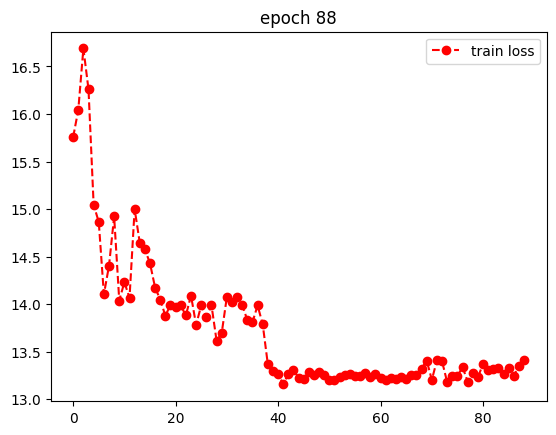

Time		0.18 sec 

EPOCH  88 	LOSS  13.417029272541614
-----------------------------------------------
-----------------------------------------------
41
bestvaleur 13.154850235428976
TEACHER FORCE RATIO	 0.0


In [ ]:
print("TRAIN")
model.train()
print("path mode\t",path_mode)

save_path = "/notebook_data/Introvert_ResnetTransf/save_models/cross_attention/"
loss  = train(model, optimizer, scheduler, criterion, criterion_vision, clip, train_loader, validation_loader, save_path)
print("LOSS ",loss)